In [1]:
%%capture
import tensorflow as tf
from tensorflow.keras.models import model_from_json
from PIL import Image
import numpy as np
import picamera
from random import random, randint
import easygopigo3 as easy
import time
import cv2
import matplotlib.pyplot as plt

my_gpg3 = easy.EasyGoPiGo3()
camera = picamera.PiCamera()

## Load the trained model

In [2]:
#pip install h5py

json_file = open('model_crop60_1210_2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)#, custom_objects={'name': name})
loaded_model.load_weights("model_crop60_1210_2.h5")

loaded_model.compile(loss = 'mse', optimizer = tf.train.AdamOptimizer())
# pred = loaded_model.predict(x_test).flatten()

In [3]:
def combinedThreshBinaryImg(img, threshX, threshY, threshColorS, threshColorU, threshColorR):

    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float)
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV).astype(np.float)
    L = hls[:,:,1]
    S = hls[:,:,2]
    R = rgb[:,:,0]
    U = yuv[:,:,1]
    sobelX = absSobelThresh(img, orient='x', thresh=(threshX[0], threshX[1]))
    sobelY = absSobelThresh(img, orient='y', thresh=(threshY[0], threshY[1]))
    sBinary = np.zeros_like(S)
    sBinary[(S >= threshColorS[0]) & (S <= threshColorS[1])] = 1
    rBinary = np.zeros_like(R)
    rBinary[(R >= threshColorR[0]) & (R <= threshColorR[1])] = 1
    uBinary = np.zeros_like(U)
    uBinary[(U >= threshColorU[0]) & (U <= threshColorU[1])] = 1    
    colorBinary = np.dstack(( rBinary, ((sobelX == 1) & (sobelY == 1)), uBinary ))
    combinedBinary = np.zeros_like(sBinary)
    combinedBinary[(rBinary == 1) | (uBinary == 1) | ((sobelX == 1) & (sobelY == 1))] = 1
    
    return combinedBinary

In [4]:
def absSobelThresh(img, orient, thresh, sobelKernel = 19):
    
    threshMin=thresh[0]
    threshMax=thresh[1]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobelOp = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobelKernel)
    else:
        sobelOp = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobelKernel)
    absSobel = np.absolute(sobelOp)
    scaledSobel = np.uint8(255*absSobel/np.max(absSobel))
    sxbinary = np.zeros_like(scaledSobel)
    sxbinary[(scaledSobel > threshMin) & (scaledSobel < threshMax)] = 1
    binaryOutput = sxbinary 
    
    return binaryOutput

## Predicting New Pictures
#### Warm up the camera

In [5]:

camera.resolution = (128, 128)
time.sleep(2)


#### Capture Image and Pre-Processing

In [7]:
motors = {'right':2, 'left':1}

#### Predict

(128, 128, 3)
(68, 128, 3)
(68, 128)
CPU times: user 1.2 s, sys: 38.1 ms, total: 1.24 s
Wall time: 2.17 s


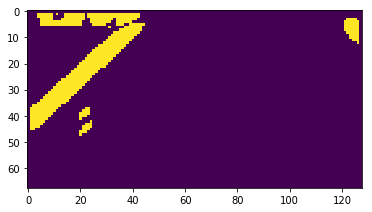

In [7]:
%%time
camera.capture('test.jpg')
image = Image.open('test.jpg')
image = np.array(image)
print(image.shape)
image = image[60:,]
print(image.shape)
image = combinedThreshBinaryImg(image, threshX=(1, 255), 
                                                threshY=(50, 255), 
                                                threshColorS=(1,255), 
                                                threshColorU=(250,250), 
                                             threshColorR=(230,255))
print(image.shape)
plt.imshow(image)
image = image.reshape((1,68,128,1))
# image.dtype='uint8'
# print(image.shape)
# cv2.imwrite('out.jpg', image)
pred = loaded_model.predict(image)

In [8]:
%%time
camera.capture('test.jpg', use_video_port=True)
image = Image.open('test.jpg')
image = np.array(image)
# plt.imshow(image)

CPU times: user 19.5 ms, sys: 10.6 ms, total: 30 ms
Wall time: 116 ms


In [24]:
type(out)

_io.TextIOWrapper

In [9]:
loaded_model.predict(image)

ValueError: Error when checking input: expected images to have 4 dimensions, but got array with shape (128, 128, 3)

In [12]:
pred

[array([[98.754486]], dtype=float32), array([[98.478516]], dtype=float32)]

In [13]:
dr_dict = {0:0, 1:-1, 2:1}

In [14]:
mag = pred[0][0][0]
dr = dr_dict[np.argmax(pred[1][0][0])]

In [23]:
dr

0

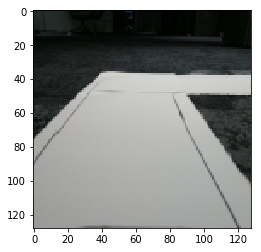

In [67]:
camera.capture('test.jpg')
image = Image.open('test.jpg')
image = np.array(image)


In [11]:
my_gpg3.stop()

In [ ]:
for i in range(100000):
    camera.capture('test.jpg', use_video_port=True)
    image = Image.open('test.jpg')
    image = np.array(image)
    image = image[60:,]
    image = combinedThreshBinaryImg(image, threshX=(1, 255), 
                                                    threshY=(50, 255), 
                                                    threshColorS=(1,255), 
                                                    threshColorU=(250,250), 
                                                 threshColorR=(230,255))
#     plt.imshow(image)
#     plt.show()
    image = image.reshape((1,68,128,1))
    pred = loaded_model.predict(image)
#     mag = pred[0][0][0]
#     dr = dr_dict[np.argmax(pred[1][0][0])]
#     print((pred[0][0][0],pred[1][0][0]))
#     pred = loaded_model.predict(image)
    speed_factor = 1
    left_speed = speed_factor*pred[0][0][0]
    right_speed = speed_factor*pred[1][0][0]
    current_speed_right = my_gpg3.set_motor_dps(motors['right'],right_speed)
    current_speed_left = my_gpg3.set_motor_dps(motors['left'],left_speed)
#     time.sleep(.1)
#     my_gpg3.stop()
my_gpg3.stop()